# Setup
- [link dataset](https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data?select=dataset)

In [1]:
!pip install -q opendatasets
!pip install -q split-folders

### import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib, zipfile, os, splitfolders
import opendatasets as od
import pandas as pd
import seaborn as sns

### download dataset

In [3]:
od.download('https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data?select=dataset')

100%|██████████| 1.98G/1.98G [00:16<00:00, 128MB/s]


### split data into train and val

In [4]:
PATH = '/content/emotion-recognition-dataset/dataset'

In [5]:
splitfolders.ratio(PATH, output='/content/project', seed=64, ratio=(0.8, 0.2))
train_dir = '/content/project/train'
validation_dir = '/content/project/val'

Copying files: 15453 files [00:08, 1858.81 files/s]


### define variables

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

### create tf dataset

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 12361 files belonging to 6 classes.


In [8]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 3092 files belonging to 6 classes.


In [9]:
class_names = train_dataset.class_names
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

print("Class Names:", class_names)
print("Class Indices:", class_indices)

Class Names: ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Class Indices: {'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


# Data exploration

### show the first 9 images from the dataset

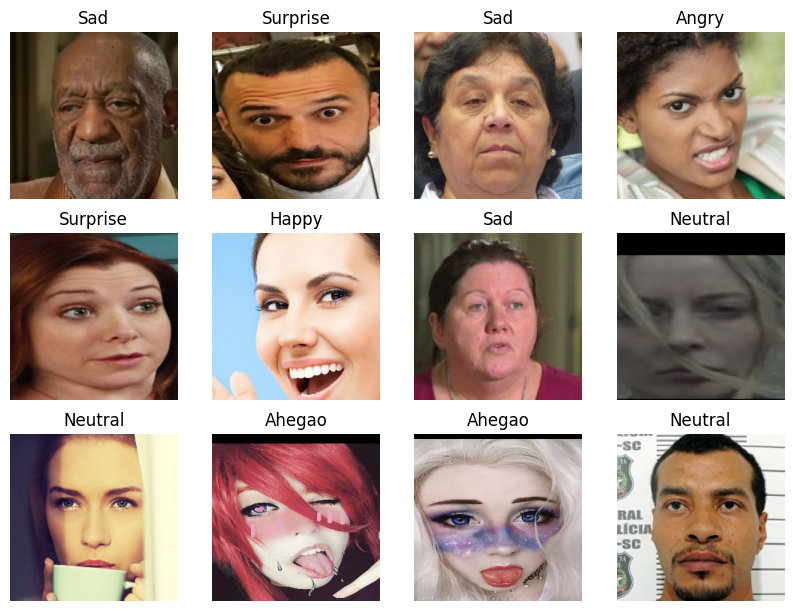

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### show data samples

In [11]:
def total_sample(directory):
  total = 0
  for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    total += len(os.listdir(folder_path))

  return total

train_sample_length = total_sample(train_dir)
validation_sample_length = total_sample(validation_dir)
print(f"The train directory has {train_sample_length} samples")
print(f"The validation directory has {validation_sample_length} samples")
print(f"Which in total makes it {train_sample_length + validation_sample_length} samples")

The train directory has 12361 samples
The validation directory has 3092 samples
Which in total makes it 15453 samples


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Surprise'),
  Text(1, 0, 'Sad'),
  Text(2, 0, 'Ahegao'),
  Text(3, 0, 'Happy'),
  Text(4, 0, 'Neutral'),
  Text(5, 0, 'Angry')])

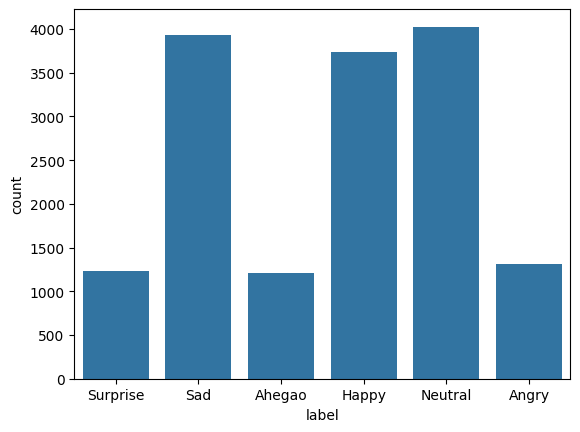

In [12]:
df = pd.read_csv('/content/emotion-recognition-dataset/data.csv')

sns.countplot(x = df['label'])
plt.xticks(rotation = 0)

# Preprocessing

### configure dataset performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### implement data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(width_factor=0.2, height_factor=0.2),
    tf.keras.layers.RandomWidth(factor=0.2),
    tf.keras.layers.RandomHeight(factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.1)
])

### visualize data augmentation

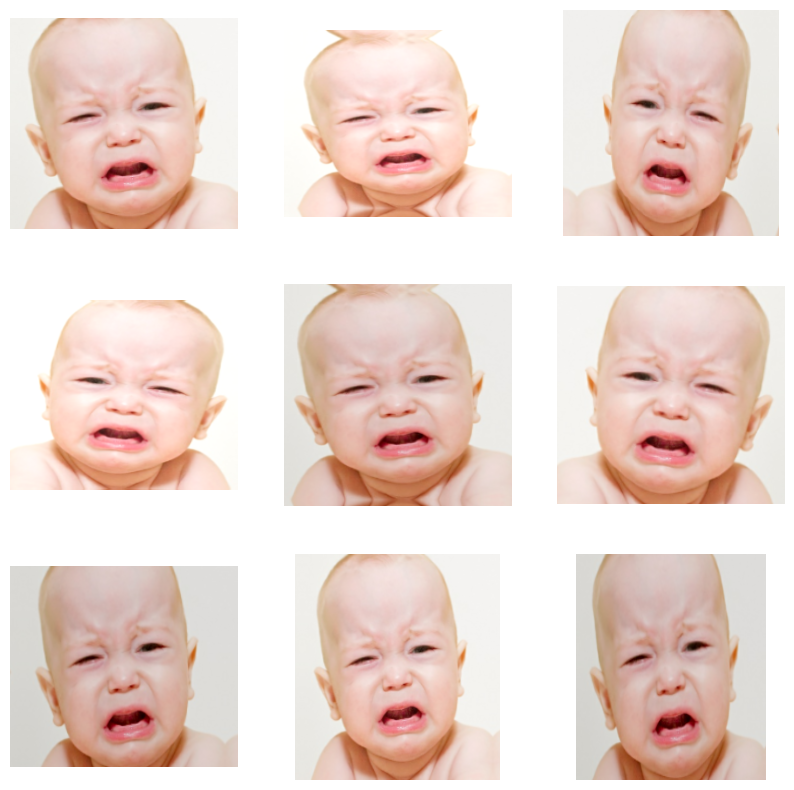

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### rescale pixel values

In [16]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Model Creation

### callback functions

In [17]:
class SudahWoi(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92:
      print(f"The model accuracy has reached 92%, stopping training")
      self.model.stop_training = True

model_complete = SudahWoi()

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("my_model_{val_accuracy:.2f}.h5", monitor="val_accuracy", verbose=0, mode="max", save_best_only=True)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1)

In [20]:
class LearningRateLogger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print(f"Epoch {epoch+1}/{self.params['epochs']}, Learning Rate: {self.model.optimizer.lr.numpy()}")

log_lr = LearningRateLogger()

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=3,
    factor=0.8,
    verbose=1,
    mode="max",
    min_lr=0.00001
)

### create base model

In [35]:
from tensorflow.keras.applications import MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=IMG_SHAPE)
)

base_model.trainable = False

In [36]:
model = tf.keras.Sequential()
model.add(Input(shape=(IMG_SHAPE)))
model.add(data_augmentation)
model.add(rescale)
model.add(base_model)
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation=tf.nn.relu))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(Dense(6, activation=tf.nn.softmax))

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_5 (Bat  (None, None, None, 1280   5120      
 chNormalization)            )                                   
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   1474688   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, None, None, 128)  

In [38]:
int_lr = 1e-3
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=int_lr, momentum=0.9),
    loss = "sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [39]:
initial_epochs = 20

loss0, acc0 = model.evaluate(validation_dataset)

97/97 [==============================] - 15s 123ms/step - loss: 2.3574 - accuracy: 0.0731


In [40]:
modelku = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_complete, checkpoint],
    verbose=2
)

Epoch 1/20

Epoch 1: val_accuracy did not improve from 0.66818
387/387 - 75s - loss: 1.5055 - accuracy: 0.4377 - val_loss: 1.0973 - val_accuracy: 0.5741 - 75s/epoch - 194ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.66818
387/387 - 71s - loss: 1.1691 - accuracy: 0.5445 - val_loss: 1.0025 - val_accuracy: 0.6016 - 71s/epoch - 184ms/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.66818
387/387 - 68s - loss: 1.0910 - accuracy: 0.5715 - val_loss: 0.9533 - val_accuracy: 0.6132 - 68s/epoch - 175ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.66818
387/387 - 69s - loss: 1.0157 - accuracy: 0.6009 - val_loss: 0.9245 - val_accuracy: 0.6235 - 69s/epoch - 178ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.66818
387/387 - 75s - loss: 0.9947 - accuracy: 0.6086 - val_loss: 0.8971 - val_accuracy: 0.6378 - 75s/epoch - 195ms/step
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.66818
387/387 - 66s - loss: 0.9637 - accuracy: 0.6219

### plot transfer learning

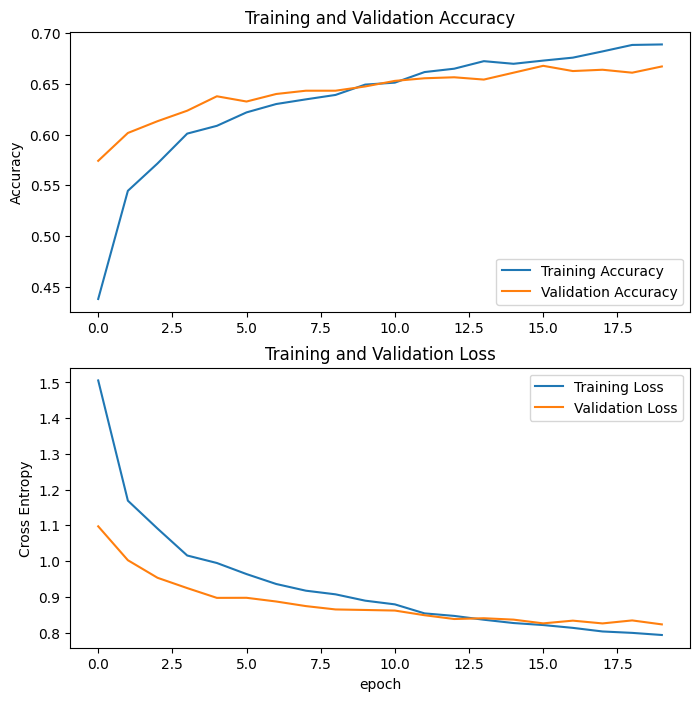

In [41]:
acc = modelku.history['accuracy']
val_acc = modelku.history['val_accuracy']

loss = modelku.history['loss']
val_loss = modelku.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [42]:
base_model.trainable = True

In [43]:
print("Jumlah layer di base model: ", len(base_model.layers))

fine_tune_di = 100

for layer in base_model.layers[:fine_tune_di]:
  layer.trainable = False

Jumlah layer di base model:  154


In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=int_lr/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_5 (Bat  (None, None, None, 1280   5120      
 chNormalization)            )                                   
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   1474688   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, None, None, 128)  

In [49]:
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

modelku_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=modelku.epoch[-1],
    validation_data=validation_dataset,
    verbose=2,
    callbacks=[early_stopping, reduce_lr, log_lr, model_complete, checkpoint]
)

Epoch 20/40
Epoch 20/40, Learning Rate: 9.999999747378752e-05

Epoch 20: val_accuracy improved from 0.71119 to 0.78525, saving model to my_model_0.79.h5
387/387 - 67s - loss: 0.5461 - accuracy: 0.7889 - val_loss: 0.5522 - val_accuracy: 0.7853 - lr: 1.0000e-04 - 67s/epoch - 173ms/step
Epoch 21/40
Epoch 21/40, Learning Rate: 9.999999747378752e-05

Epoch 21: val_accuracy did not improve from 0.78525
387/387 - 65s - loss: 0.4955 - accuracy: 0.8113 - val_loss: 0.6125 - val_accuracy: 0.7671 - lr: 1.0000e-04 - 65s/epoch - 168ms/step
Epoch 22/40
Epoch 22/40, Learning Rate: 9.999999747378752e-05

Epoch 22: val_accuracy did not improve from 0.78525
387/387 - 63s - loss: 0.4549 - accuracy: 0.8261 - val_loss: 0.5849 - val_accuracy: 0.7781 - lr: 1.0000e-04 - 63s/epoch - 164ms/step
Epoch 23/40
Epoch 23/40, Learning Rate: 9.999999747378752e-05

Epoch 23: val_accuracy improved from 0.78525 to 0.79819, saving model to my_model_0.80.h5
387/387 - 63s - loss: 0.4014 - accuracy: 0.8488 - val_loss: 0.5266 -

### plot fine tuning

In [50]:
acc += modelku_fine.history['accuracy']
val_acc += modelku_fine.history['val_accuracy']

loss += modelku_fine.history['loss']
val_loss += modelku_fine.history['val_loss']

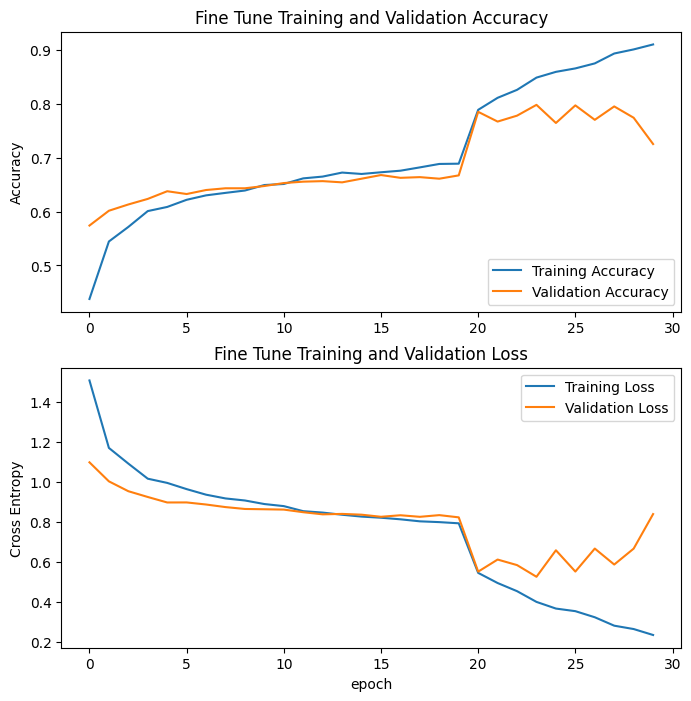

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Fine Tune Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Fine Tune Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model Evaluation

In [52]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

97/97 [==============================] - 14s 128ms/step - loss: 0.5266 - accuracy: 0.7982
Validation accuracy : 0.7981888651847839


### predict image

In [53]:
from google.colab import files
uploaded = files.upload()

Saving ahegao.png to ahegao.png
Saving angry.png to angry.png
Saving happy.png to happy.png
Saving neutral.png to neutral.png
Saving sad.png to sad.png
Saving surprised.png to surprised.png


1/1 [==============================] - 0s 25ms/step


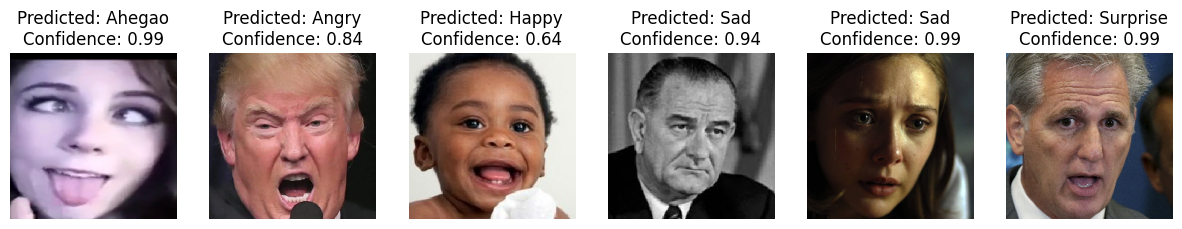

In [54]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

class_labels = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

fig , axs = plt.subplots(1, len(uploaded), figsize=(15,5))

for i, fn in enumerate(uploaded.keys()):

  #predict gambar
  path = fn
  img = image.load_img(path, target_size=IMG_SIZE)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  confidence_score = classes[0][predicted_index]

  predicted_label = class_labels[predicted_index]

  axs[i].imshow(img)
  axs[i].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence_score:.2f}")
  axs[i].axis('off')

plt.show()

# Save Model

In [ ]:
# menyimpan model dalam format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)